In [13]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def get_image_paths(folder):
    img_dir = os.path.join(folder, "image")
    return [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.png')]

all_image_paths = []
for split in ["train", "val", "test"]:
    all_image_paths.extend(get_image_paths(split))

means = []
stds = []

for img_path in tqdm(all_image_paths, desc="Calculating mean/std"):
    img = Image.open(img_path).convert("RGB")
    img = np.array(img) / 255.0  # scale to [0,1]
    means.append(np.mean(img, axis=(0,1)))
    stds.append(np.std(img, axis=(0,1)))

mean = np.mean(means, axis=0)
std = np.mean(stds, axis=0)

print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Calculating mean/std: 100%|██████████| 300/300 [00:01<00:00, 252.51it/s]

Dataset mean: [0.11803523 0.12175034 0.12110489]
Dataset std: [0.16351671 0.16600904 0.16600859]


U-Net

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# -----------------------
# Dataset
# -----------------------
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # assumes same filename

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        if self.transform is not None:
            image = self.transform(image)
            # For mask: only resize and ToTensor, no Normalize!
            mask_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask)

        mask = (mask > 0).float()  # binarize
        return image, mask

# -----------------------
# U-Net
# -----------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.conv_final(d1))

# -----------------------
# Metrics
# -----------------------
def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)).item()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return ((intersection + smooth) / (union + smooth)).item()

def pixel_accuracy(pred, target):
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    return (correct / target.numel()).item()

def precision_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    return (tp / (tp + fp + smooth)).item()

def recall_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()
    return (tp / (tp + fn + smooth)).item()

# -----------------------
# Data Setup
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.11803523, 0.12175034, 0.12110489], std=[0.16351671, 0.16600904, 0.16600859])
])

train_dataset = SegmentationDataset(
    img_dir="train/image",
    mask_dir="train/mask",
    transform=transform
)
val_dataset = SegmentationDataset(
    img_dir="val/image",
    mask_dir="val/mask",
    transform=transform
)
test_dataset = SegmentationDataset(
    img_dir="test/image",
    mask_dir="test/mask",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# -----------------------
# U-Net Training
# -----------------------
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
bce = nn.BCELoss()

num_epochs = 20
u_net_best_val_loss = float("inf")
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    u_net_train_loss, u_net_train_dice, u_net_train_iou, u_net_train_acc = 0, 0, 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        u_net_train_loss += loss.item()
        u_net_train_dice += dice_score(preds, masks)
        u_net_train_iou += iou_score(preds, masks)
        u_net_train_acc += pixel_accuracy(preds, masks)

    # --- Validation ---
    model.eval()
    u_net_val_loss, u_net_val_dice, u_net_val_iou, u_net_val_acc, u_net_val_prec, u_net_val_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            u_net_val_loss += loss.item()
            u_net_val_dice += dice_score(preds, masks)
            u_net_val_iou += iou_score(preds, masks)
            u_net_val_acc += pixel_accuracy(preds, masks)
            u_net_val_prec += precision_score(preds, masks)
            u_net_val_rec += recall_score(preds, masks)

    # --- Test ---
    u_net_test_loss, u_net_test_dice, u_net_test_iou, u_net_test_acc, u_net_test_prec, u_net_test_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Test"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            u_net_test_loss += loss.item()
            u_net_test_dice += dice_score(preds, masks)
            u_net_test_iou += iou_score(preds, masks)
            u_net_test_acc += pixel_accuracy(preds, masks)
            u_net_test_prec += precision_score(preds, masks)
            u_net_test_rec += recall_score(preds, masks)

    # --- Print metrics ---
    print(f"\nEpoch {epoch+1}:")
    print(f" Train Loss={u_net_train_loss/len(train_loader):.4f} | "
          f"Dice={u_net_train_dice/len(train_loader):.4f} | IoU={u_net_train_iou/len(train_loader):.4f} | Acc={u_net_train_acc/len(train_loader):.4f}")
    print(f" Val   Loss={u_net_val_loss/len(val_loader):.4f} | "
          f"Dice={u_net_val_dice/len(val_loader):.4f} | IoU={u_net_val_iou/len(val_loader):.4f} | Acc={u_net_val_acc/len(val_loader):.4f} | "
          f"Prec={u_net_val_prec/len(val_loader):.4f} | Recall={u_net_val_rec/len(val_loader):.4f}")
    print(f" Test  Loss={u_net_test_loss/len(test_loader):.4f} | "
          f"Dice={u_net_test_dice/len(test_loader):.4f} | IoU={u_net_test_iou/len(test_loader):.4f} | Acc={u_net_test_acc/len(test_loader):.4f} | "
          f"Prec={u_net_test_prec/len(test_loader):.4f} | Recall={u_net_test_rec/len(test_loader):.4f}")

    # --- Early stopping ---
    if u_net_val_loss < u_net_best_val_loss:
        u_net_best_val_loss = u_net_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_unet.pth")
        print("✅ Model saved!")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} of {patience}")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break


Epoch 1/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.23it/s]



Epoch 1:
 Train Loss=0.7557 | Dice=0.0438 | IoU=0.0224 | Acc=0.8897
 Val   Loss=0.7688 | Dice=0.0499 | IoU=0.0256 | Acc=0.9297 | Prec=0.0265 | Recall=0.4446
 Test  Loss=0.7658 | Dice=0.0548 | IoU=0.0283 | Acc=0.9317 | Prec=0.0296 | Recall=0.4225
✅ Model saved!


Epoch 2/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]



Epoch 2:
 Train Loss=0.6932 | Dice=0.0388 | IoU=0.0202 | Acc=0.9881
 Val   Loss=0.6923 | Dice=0.0000 | IoU=0.0000 | Acc=0.9933 | Prec=0.0000 | Recall=0.0000
 Test  Loss=0.6923 | Dice=0.0000 | IoU=0.0000 | Acc=0.9929 | Prec=0.0000 | Recall=0.0000
✅ Model saved!


Epoch 3/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 10.71it/s]



Epoch 3:
 Train Loss=0.6407 | Dice=0.0655 | IoU=0.0367 | Acc=0.9945
 Val   Loss=0.6480 | Dice=0.0411 | IoU=0.0214 | Acc=0.9947 | Prec=0.0859 | Recall=0.0271
 Test  Loss=0.6476 | Dice=0.0419 | IoU=0.0220 | Acc=0.9943 | Prec=0.0889 | Recall=0.0277
✅ Model saved!


Epoch 4/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]



Epoch 4:
 Train Loss=0.5156 | Dice=0.2876 | IoU=0.1748 | Acc=0.9956
 Val   Loss=0.4903 | Dice=0.3295 | IoU=0.2008 | Acc=0.9959 | Prec=0.4827 | Recall=0.2548
 Test  Loss=0.4944 | Dice=0.3214 | IoU=0.2026 | Acc=0.9955 | Prec=0.4621 | Recall=0.2566
✅ Model saved!


Epoch 5/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]



Epoch 5:
 Train Loss=0.3653 | Dice=0.5690 | IoU=0.4078 | Acc=0.9968
 Val   Loss=0.3028 | Dice=0.6857 | IoU=0.5242 | Acc=0.9974 | Prec=0.6559 | Recall=0.7287
 Test  Loss=0.3152 | Dice=0.6610 | IoU=0.4995 | Acc=0.9969 | Prec=0.6341 | Recall=0.7048
✅ Model saved!


Epoch 6/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]



Epoch 6:
 Train Loss=0.2827 | Dice=0.7180 | IoU=0.5620 | Acc=0.9976
 Val   Loss=0.3447 | Dice=0.5903 | IoU=0.4277 | Acc=0.9972 | Prec=0.7033 | Recall=0.5139
 Test  Loss=0.3495 | Dice=0.5809 | IoU=0.4205 | Acc=0.9968 | Prec=0.6932 | Recall=0.5251
EarlyStopping counter: 1 of 5


Epoch 7/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.44it/s]



Epoch 7:
 Train Loss=0.2611 | Dice=0.7468 | IoU=0.5983 | Acc=0.9978
 Val   Loss=0.2567 | Dice=0.7527 | IoU=0.6060 | Acc=0.9981 | Prec=0.7617 | Recall=0.7456
 Test  Loss=0.2743 | Dice=0.7179 | IoU=0.5653 | Acc=0.9975 | Prec=0.7239 | Recall=0.7270
✅ Model saved!


Epoch 8/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]



Epoch 8:
 Train Loss=0.2336 | Dice=0.7884 | IoU=0.6517 | Acc=0.9982
 Val   Loss=0.2507 | Dice=0.7520 | IoU=0.6078 | Acc=0.9983 | Prec=0.8807 | Recall=0.6619
 Test  Loss=0.2709 | Dice=0.7120 | IoU=0.5642 | Acc=0.9978 | Prec=0.8557 | Recall=0.6346
✅ Model saved!


Epoch 9/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.39it/s]



Epoch 9:
 Train Loss=0.2171 | Dice=0.8089 | IoU=0.6800 | Acc=0.9983
 Val   Loss=0.2422 | Dice=0.7497 | IoU=0.6029 | Acc=0.9982 | Prec=0.8705 | Recall=0.6636
 Test  Loss=0.2598 | Dice=0.7149 | IoU=0.5646 | Acc=0.9978 | Prec=0.8229 | Recall=0.6545
✅ Model saved!


Epoch 10/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]



Epoch 10:
 Train Loss=0.2004 | Dice=0.8306 | IoU=0.7108 | Acc=0.9985
 Val   Loss=0.2063 | Dice=0.8130 | IoU=0.6858 | Acc=0.9985 | Prec=0.8178 | Recall=0.8127
 Test  Loss=0.2210 | Dice=0.7840 | IoU=0.6484 | Acc=0.9981 | Prec=0.7932 | Recall=0.7876
✅ Model saved!


Epoch 11/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.03it/s]



Epoch 11:
 Train Loss=0.1895 | Dice=0.8418 | IoU=0.7273 | Acc=0.9986
 Val   Loss=0.2005 | Dice=0.8137 | IoU=0.6867 | Acc=0.9985 | Prec=0.8048 | Recall=0.8236
 Test  Loss=0.2237 | Dice=0.7679 | IoU=0.6260 | Acc=0.9979 | Prec=0.7602 | Recall=0.7846
✅ Model saved!


Epoch 12/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]



Epoch 12:
 Train Loss=0.1769 | Dice=0.8568 | IoU=0.7502 | Acc=0.9988
 Val   Loss=0.1926 | Dice=0.8203 | IoU=0.6961 | Acc=0.9986 | Prec=0.8314 | Recall=0.8122
 Test  Loss=0.2082 | Dice=0.7895 | IoU=0.6549 | Acc=0.9981 | Prec=0.7923 | Recall=0.7946
✅ Model saved!


Epoch 13/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.31it/s]



Epoch 13:
 Train Loss=0.1725 | Dice=0.8564 | IoU=0.7496 | Acc=0.9988
 Val   Loss=0.2114 | Dice=0.7718 | IoU=0.6346 | Acc=0.9985 | Prec=0.9275 | Recall=0.6726
 Test  Loss=0.2311 | Dice=0.7330 | IoU=0.5888 | Acc=0.9981 | Prec=0.8855 | Recall=0.6502
EarlyStopping counter: 1 of 5


Epoch 14/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.60it/s]



Epoch 14:
 Train Loss=0.1622 | Dice=0.8680 | IoU=0.7675 | Acc=0.9989
 Val   Loss=0.1703 | Dice=0.8457 | IoU=0.7338 | Acc=0.9988 | Prec=0.8647 | Recall=0.8288
 Test  Loss=0.1917 | Dice=0.8035 | IoU=0.6743 | Acc=0.9982 | Prec=0.8124 | Recall=0.8060
✅ Model saved!


Epoch 15/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.48it/s]



Epoch 15:
 Train Loss=0.1545 | Dice=0.8751 | IoU=0.7785 | Acc=0.9989
 Val   Loss=0.1817 | Dice=0.8173 | IoU=0.6916 | Acc=0.9985 | Prec=0.7986 | Recall=0.8425
 Test  Loss=0.2003 | Dice=0.7806 | IoU=0.6438 | Acc=0.9980 | Prec=0.7688 | Recall=0.8077
EarlyStopping counter: 1 of 5


Epoch 16/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.55it/s]



Epoch 16:
 Train Loss=0.1491 | Dice=0.8779 | IoU=0.7828 | Acc=0.9989
 Val   Loss=0.1664 | Dice=0.8392 | IoU=0.7237 | Acc=0.9987 | Prec=0.8677 | Recall=0.8135
 Test  Loss=0.1857 | Dice=0.8013 | IoU=0.6711 | Acc=0.9982 | Prec=0.8234 | Recall=0.7934
✅ Model saved!


Epoch 17/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.47it/s]



Epoch 17:
 Train Loss=0.1456 | Dice=0.8775 | IoU=0.7823 | Acc=0.9990
 Val   Loss=0.1715 | Dice=0.8225 | IoU=0.6998 | Acc=0.9986 | Prec=0.8604 | Recall=0.7901
 Test  Loss=0.1901 | Dice=0.7859 | IoU=0.6512 | Acc=0.9981 | Prec=0.8112 | Recall=0.7798
EarlyStopping counter: 1 of 5


Epoch 18/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]



Epoch 18:
 Train Loss=0.1380 | Dice=0.8856 | IoU=0.7952 | Acc=0.9990
 Val   Loss=0.1701 | Dice=0.8181 | IoU=0.6932 | Acc=0.9986 | Prec=0.8486 | Recall=0.7921
 Test  Loss=0.1903 | Dice=0.7784 | IoU=0.6423 | Acc=0.9981 | Prec=0.8102 | Recall=0.7582
EarlyStopping counter: 2 of 5


Epoch 19/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]



Epoch 19:
 Train Loss=0.1316 | Dice=0.8917 | IoU=0.8053 | Acc=0.9991
 Val   Loss=0.1548 | Dice=0.8430 | IoU=0.7306 | Acc=0.9988 | Prec=0.8811 | Recall=0.8138
 Test  Loss=0.1759 | Dice=0.8012 | IoU=0.6728 | Acc=0.9983 | Prec=0.8332 | Recall=0.7905
✅ Model saved!


Epoch 20/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.14it/s]



Epoch 20:
 Train Loss=0.1241 | Dice=0.9001 | IoU=0.8189 | Acc=0.9991
 Val   Loss=0.1487 | Dice=0.8493 | IoU=0.7397 | Acc=0.9988 | Prec=0.8809 | Recall=0.8221
 Test  Loss=0.1719 | Dice=0.8036 | IoU=0.6750 | Acc=0.9983 | Prec=0.8318 | Recall=0.7917
✅ Model saved!


In [15]:
print(f"Best Test Loss: {u_net_test_loss/len(test_loader):.4f} at epoch {epoch + 1 - epochs_no_improve}")
print(f"Best Test Dice: {u_net_test_dice/len(test_loader):.4f}")
print(f"Best Test IoU: {u_net_test_iou/len(test_loader):.4f}")
print(f"Best Test Accuracy: {u_net_test_acc/len(test_loader):.4f}")
print(f"Best Test Precision: {u_net_test_prec/len(test_loader):.4f}")
print(f"Best Test Recall: {u_net_test_rec/len(test_loader):.4f}")

Best Test Loss: 0.1719 at epoch 20
Best Test Dice: 0.8036
Best Test IoU: 0.6750
Best Test Accuracy: 0.9983
Best Test Precision: 0.8318
Best Test Recall: 0.7917


In [16]:
u_net_loss = u_net_test_loss/len(test_loader)
u_net_dice = u_net_test_dice/len(test_loader)
u_net_iou = u_net_test_iou/len(test_loader)

In [17]:
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

# -----------------------
# DeepLabV3 Model
# -----------------------
class DeepLabV3(nn.Module):
    def __init__(self, num_classes=1):
        super(DeepLabV3, self).__init__()
        self.model = deeplabv3_resnet50(weights=None, num_classes=1)
        # If you want to use pretrained backbone:
        self.model = deeplabv3_resnet50(weights="DEFAULT")
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        out = self.model(x)['out']
        return torch.sigmoid(out)

# -----------------------
# Training DeepLabV3
# -----------------------
deeplab_model = DeepLabV3().to(device)
optimizer = optim.Adam(deeplab_model.parameters(), lr=1e-4)
bce = nn.BCELoss()
num_epochs = 20
deep_lab_best_val_loss = float("inf")
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    deeplab_model.train()
    deep_lab_train_loss, deep_lab_train_dice, deep_lab_train_iou, deep_lab_train_acc = 0, 0, 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"DeepLabV3 Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = deeplab_model(imgs)
        loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        deep_lab_train_loss += loss.item()
        deep_lab_train_dice += dice_score(preds, masks)
        deep_lab_train_iou += iou_score(preds, masks)
        deep_lab_train_acc += pixel_accuracy(preds, masks)

    # --- Validation ---
    deeplab_model.eval()
    deep_lab_val_loss, deep_lab_val_dice, deep_lab_val_iou, deep_lab_val_acc, deep_lab_val_prec, deep_lab_val_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"DeepLabV3 Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = deeplab_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            deep_lab_val_loss += loss.item()
            deep_lab_val_dice += dice_score(preds, masks)
            deep_lab_val_iou += iou_score(preds, masks)
            deep_lab_val_acc += pixel_accuracy(preds, masks)
            deep_lab_val_prec += precision_score(preds, masks)
            deep_lab_val_rec += recall_score(preds, masks)

    # --- Test ---
    deep_lab_test_loss, deep_lab_test_dice, deep_lab_test_iou, deep_lab_test_acc, deep_lab_test_prec, deep_lab_test_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"DeepLabV3 Epoch {epoch+1}/{num_epochs} - Test"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = deeplab_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            deep_lab_test_loss += loss.item()
            deep_lab_test_dice += dice_score(preds, masks)
            deep_lab_test_iou += iou_score(preds, masks)
            deep_lab_test_acc += pixel_accuracy(preds, masks)
            deep_lab_test_prec += precision_score(preds, masks)
            deep_lab_test_rec += recall_score(preds, masks)

    # --- Print metrics ---
    print(f"\nDeepLabV3 Epoch {epoch+1}:")
    print(f" Train Loss={deep_lab_train_loss/len(train_loader):.4f} | "
          f"Dice={deep_lab_train_dice/len(train_loader):.4f} | IoU={deep_lab_train_iou/len(train_loader):.4f} | Acc={deep_lab_train_acc/len(train_loader):.4f}")
    print(f" Val   Loss={deep_lab_val_loss/len(val_loader):.4f} | "
          f"Dice={deep_lab_val_dice/len(val_loader):.4f} | IoU={deep_lab_val_iou/len(val_loader):.4f} | Acc={deep_lab_val_acc/len(val_loader):.4f} | "
          f"Prec={deep_lab_val_prec/len(val_loader):.4f} | Recall={deep_lab_val_rec/len(val_loader):.4f}")
    print(f" Test  Loss={deep_lab_test_loss/len(test_loader):.4f} | "
          f"Dice={deep_lab_test_dice/len(test_loader):.4f} | IoU={deep_lab_test_iou/len(test_loader):.4f} | Acc={deep_lab_test_acc/len(test_loader):.4f} | "
          f"Prec={deep_lab_test_prec/len(test_loader):.4f} | Recall={deep_lab_test_rec/len(test_loader):.4f}")

    # --- Early stopping ---
    if deep_lab_val_loss < deep_lab_best_val_loss:
        deep_lab_best_val_loss = deep_lab_val_loss
        epochs_no_improve = 0
        torch.save(deeplab_model.state_dict(), "best_deeplabv3.pth")
        print("✅ DeepLabV3 Model saved!")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} of {patience}")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

DeepLabV3 Epoch 1/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.02it/s]



DeepLabV3 Epoch 1:
 Train Loss=0.7688 | Dice=0.0289 | IoU=0.0148 | Acc=0.9028
 Val   Loss=0.7084 | Dice=0.0268 | IoU=0.0138 | Acc=0.9767 | Prec=0.0154 | Recall=0.1336
 Test  Loss=0.7075 | Dice=0.0259 | IoU=0.0132 | Acc=0.9785 | Prec=0.0188 | Recall=0.0980
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 2/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]



DeepLabV3 Epoch 2:
 Train Loss=0.6920 | Dice=0.0091 | IoU=0.0047 | Acc=0.9945
 Val   Loss=0.6693 | Dice=0.0193 | IoU=0.0099 | Acc=0.9933 | Prec=0.0189 | Recall=0.0273
 Test  Loss=0.6751 | Dice=0.0063 | IoU=0.0032 | Acc=0.9944 | Prec=0.0052 | Recall=0.0081
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 3/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]



DeepLabV3 Epoch 3:
 Train Loss=0.6631 | Dice=0.0044 | IoU=0.0022 | Acc=0.9945
 Val   Loss=0.6305 | Dice=0.0362 | IoU=0.0188 | Acc=0.9915 | Prec=0.0278 | Recall=0.0645
 Test  Loss=0.6313 | Dice=0.0335 | IoU=0.0175 | Acc=0.9920 | Prec=0.0310 | Recall=0.0438
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 4/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]



DeepLabV3 Epoch 4:
 Train Loss=0.6327 | Dice=0.0124 | IoU=0.0063 | Acc=0.9951
 Val   Loss=0.6108 | Dice=0.0390 | IoU=0.0203 | Acc=0.9939 | Prec=0.0507 | Recall=0.0439
 Test  Loss=0.6111 | Dice=0.0394 | IoU=0.0207 | Acc=0.9942 | Prec=0.0784 | Recall=0.0354
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 5/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]



DeepLabV3 Epoch 5:
 Train Loss=0.6042 | Dice=0.0385 | IoU=0.0206 | Acc=0.9953
 Val   Loss=0.5951 | Dice=0.0909 | IoU=0.0500 | Acc=0.9915 | Prec=0.1111 | Recall=0.1735
 Test  Loss=0.5999 | Dice=0.0604 | IoU=0.0328 | Acc=0.9931 | Prec=0.0703 | Recall=0.0901
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 6/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.29it/s]



DeepLabV3 Epoch 6:
 Train Loss=0.5754 | Dice=0.0680 | IoU=0.0363 | Acc=0.9955
 Val   Loss=0.5110 | Dice=0.1780 | IoU=0.1038 | Acc=0.9955 | Prec=0.4763 | Recall=0.1302
 Test  Loss=0.5340 | Dice=0.1302 | IoU=0.0837 | Acc=0.9952 | Prec=0.3254 | Recall=0.0991
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 7/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 14.06it/s]



DeepLabV3 Epoch 7:
 Train Loss=0.3811 | Dice=0.4340 | IoU=0.2921 | Acc=0.9964
 Val   Loss=0.4360 | Dice=0.3250 | IoU=0.2115 | Acc=0.9930 | Prec=0.3608 | Recall=0.3817
 Test  Loss=0.4297 | Dice=0.3358 | IoU=0.2194 | Acc=0.9941 | Prec=0.3676 | Recall=0.3604
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 8/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.21it/s]



DeepLabV3 Epoch 8:
 Train Loss=0.3322 | Dice=0.5088 | IoU=0.3492 | Acc=0.9964
 Val   Loss=0.3651 | Dice=0.4355 | IoU=0.3000 | Acc=0.9960 | Prec=0.5105 | Recall=0.4200
 Test  Loss=0.3691 | Dice=0.4267 | IoU=0.2904 | Acc=0.9955 | Prec=0.5761 | Recall=0.4640
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 9/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]



DeepLabV3 Epoch 9:
 Train Loss=0.2851 | Dice=0.5847 | IoU=0.4148 | Acc=0.9967
 Val   Loss=0.3555 | Dice=0.4360 | IoU=0.3050 | Acc=0.9966 | Prec=0.6007 | Recall=0.3656
 Test  Loss=0.3481 | Dice=0.4495 | IoU=0.3129 | Acc=0.9961 | Prec=0.6677 | Recall=0.4228
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 10/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]



DeepLabV3 Epoch 10:
 Train Loss=0.2606 | Dice=0.6181 | IoU=0.4527 | Acc=0.9969
 Val   Loss=0.3468 | Dice=0.4435 | IoU=0.3082 | Acc=0.9950 | Prec=0.5286 | Recall=0.4377
 Test  Loss=0.3291 | Dice=0.4759 | IoU=0.3321 | Acc=0.9956 | Prec=0.6550 | Recall=0.4694
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 11/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.88it/s]



DeepLabV3 Epoch 11:
 Train Loss=0.2275 | Dice=0.6711 | IoU=0.5086 | Acc=0.9973
 Val   Loss=0.2775 | Dice=0.5637 | IoU=0.4119 | Acc=0.9971 | Prec=0.6837 | Recall=0.5112
 Test  Loss=0.2767 | Dice=0.5666 | IoU=0.4073 | Acc=0.9966 | Prec=0.6998 | Recall=0.5373
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 12/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]



DeepLabV3 Epoch 12:
 Train Loss=0.2160 | Dice=0.6828 | IoU=0.5227 | Acc=0.9974
 Val   Loss=0.2318 | Dice=0.6429 | IoU=0.4828 | Acc=0.9975 | Prec=0.7458 | Recall=0.5835
 Test  Loss=0.2500 | Dice=0.6073 | IoU=0.4454 | Acc=0.9969 | Prec=0.7202 | Recall=0.5806
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 13/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.70it/s]



DeepLabV3 Epoch 13:
 Train Loss=0.1748 | Dice=0.7549 | IoU=0.6079 | Acc=0.9979
 Val   Loss=0.2098 | Dice=0.6793 | IoU=0.5254 | Acc=0.9975 | Prec=0.7094 | Recall=0.6883
 Test  Loss=0.2210 | Dice=0.6585 | IoU=0.4967 | Acc=0.9969 | Prec=0.6928 | Recall=0.6754
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 14/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]



DeepLabV3 Epoch 14:
 Train Loss=0.1639 | Dice=0.7666 | IoU=0.6226 | Acc=0.9980
 Val   Loss=0.2153 | Dice=0.6623 | IoU=0.5038 | Acc=0.9969 | Prec=0.6477 | Recall=0.7551
 Test  Loss=0.2281 | Dice=0.6387 | IoU=0.4774 | Acc=0.9960 | Prec=0.6564 | Recall=0.7147
EarlyStopping counter: 1 of 5


DeepLabV3 Epoch 15/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]



DeepLabV3 Epoch 15:
 Train Loss=0.1605 | Dice=0.7661 | IoU=0.6228 | Acc=0.9980
 Val   Loss=0.2606 | Dice=0.5613 | IoU=0.4049 | Acc=0.9971 | Prec=0.7556 | Recall=0.4867
 Test  Loss=0.2645 | Dice=0.5545 | IoU=0.3996 | Acc=0.9967 | Prec=0.7551 | Recall=0.4844
EarlyStopping counter: 2 of 5


DeepLabV3 Epoch 16/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]



DeepLabV3 Epoch 16:
 Train Loss=0.1533 | Dice=0.7729 | IoU=0.6322 | Acc=0.9981
 Val   Loss=0.1713 | Dice=0.7331 | IoU=0.5899 | Acc=0.9981 | Prec=0.7804 | Recall=0.7114
 Test  Loss=0.1725 | Dice=0.7311 | IoU=0.5809 | Acc=0.9976 | Prec=0.7475 | Recall=0.7311
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 17/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.79it/s]



DeepLabV3 Epoch 17:
 Train Loss=0.1410 | Dice=0.7916 | IoU=0.6557 | Acc=0.9982
 Val   Loss=0.1552 | Dice=0.7591 | IoU=0.6174 | Acc=0.9982 | Prec=0.8303 | Recall=0.7130
 Test  Loss=0.1639 | Dice=0.7423 | IoU=0.5953 | Acc=0.9978 | Prec=0.7855 | Recall=0.7234
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 18/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]



DeepLabV3 Epoch 18:
 Train Loss=0.1309 | Dice=0.8062 | IoU=0.6761 | Acc=0.9983
 Val   Loss=0.1651 | Dice=0.7357 | IoU=0.5910 | Acc=0.9981 | Prec=0.8040 | Recall=0.6960
 Test  Loss=0.1696 | Dice=0.7275 | IoU=0.5770 | Acc=0.9977 | Prec=0.7742 | Recall=0.7063
EarlyStopping counter: 1 of 5


DeepLabV3 Epoch 19/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.49it/s]



DeepLabV3 Epoch 19:
 Train Loss=0.1328 | Dice=0.7983 | IoU=0.6661 | Acc=0.9984
 Val   Loss=0.1907 | Dice=0.6792 | IoU=0.5269 | Acc=0.9978 | Prec=0.8084 | Recall=0.6246
 Test  Loss=0.1918 | Dice=0.6777 | IoU=0.5178 | Acc=0.9973 | Prec=0.7756 | Recall=0.6373
EarlyStopping counter: 2 of 5


DeepLabV3 Epoch 20/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]



DeepLabV3 Epoch 20:
 Train Loss=0.1259 | Dice=0.8069 | IoU=0.6776 | Acc=0.9984
 Val   Loss=0.1422 | Dice=0.7720 | IoU=0.6337 | Acc=0.9982 | Prec=0.7819 | Recall=0.7732
 Test  Loss=0.1503 | Dice=0.7567 | IoU=0.6117 | Acc=0.9977 | Prec=0.7596 | Recall=0.7676
✅ DeepLabV3 Model saved!


In [18]:
print(f"Best Test Loss: {deep_lab_test_loss/len(test_loader):.4f} at epoch {epoch + 1 - epochs_no_improve}")
print(f"Best Test Dice: {deep_lab_test_dice/len(test_loader):.4f}")
print(f"Best Test IoU: {deep_lab_test_iou/len(test_loader):.4f}")
print(f"Best Test Accuracy: {deep_lab_test_acc/len(test_loader):.4f}")
print(f"Best Test Precision: {deep_lab_test_prec/len(test_loader):.4f}")
print(f"Best Test Recall: {deep_lab_test_rec/len(test_loader):.4f}")

Best Test Loss: 0.1503 at epoch 20
Best Test Dice: 0.7567
Best Test IoU: 0.6117
Best Test Accuracy: 0.9977
Best Test Precision: 0.7596
Best Test Recall: 0.7676


In [19]:
deep_lab_loss = deep_lab_test_loss/len(test_loader)
deep_lab_dice = deep_lab_test_dice/len(test_loader)
deep_lab_iou = deep_lab_test_iou/len(test_loader)

In [20]:
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# -----------------------
# FPN Model
# -----------------------
class FPNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FPNHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, 128, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.out = nn.Conv2d(128, num_classes, 1)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.out(x)
        return x

class FPNNet(nn.Module):
    def __init__(self, num_classes=1):
        super(FPNNet, self).__init__()
        # Use a pre-trained ResNet50 FPN backbone
        self.backbone = resnet_fpn_backbone('resnet50', pretrained=True)
        self.head = FPNHead(256, num_classes)  # 256 is the FPN out_channels

    def forward(self, x):
        features = self.backbone(x)
        # Use the highest resolution FPN output ('0')
        x = features['0']
        x = self.head(x)
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)

# -----------------------
# Training FPN
# -----------------------
fpn_model = FPNNet().to(device)
optimizer = optim.Adam(fpn_model.parameters(), lr=1e-4)
bce = nn.BCELoss()
num_epochs = 20
best_val_loss = float("inf")
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    fpn_model.train()
    fpn_train_loss, fpn_train_dice, fpn_train_iou, fpn_train_acc = 0, 0, 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"FPN Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = fpn_model(imgs)
        loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        fpn_train_loss += loss.item()
        fpn_train_dice += dice_score(preds, masks)
        fpn_train_iou += iou_score(preds, masks)
        fpn_train_acc += pixel_accuracy(preds, masks)

    # --- Validation ---
    fpn_model.eval()
    fpn_val_loss, fpn_val_dice, fpn_val_iou, fpn_val_acc, fpn_val_prec, fpn_val_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"FPN Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = fpn_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            fpn_val_loss += loss.item()
            fpn_val_dice += dice_score(preds, masks)
            fpn_val_iou += iou_score(preds, masks)
            fpn_val_acc += pixel_accuracy(preds, masks)
            fpn_val_prec += precision_score(preds, masks)
            fpn_val_rec += recall_score(preds, masks)

    # --- Test ---
    fpn_test_loss, fpn_test_dice, fpn_test_iou, fpn_test_acc, fpn_test_prec, fpn_test_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"FPN Epoch {epoch+1}/{num_epochs} - Test"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = fpn_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            fpn_test_loss += loss.item()
            fpn_test_dice += dice_score(preds, masks)
            fpn_test_iou += iou_score(preds, masks)
            fpn_test_acc += pixel_accuracy(preds, masks)
            fpn_test_prec += precision_score(preds, masks)
            fpn_test_rec += recall_score(preds, masks)

    # --- Print metrics ---
    print(f"\nFPN Epoch {epoch+1}:")
    print(f" Train Loss={fpn_train_loss/len(train_loader):.4f} | "
          f"Dice={fpn_train_dice/len(train_loader):.4f} | IoU={fpn_train_iou/len(train_loader):.4f} | Acc={fpn_train_acc/len(train_loader):.4f}")
    print(f" Val   Loss={fpn_val_loss/len(val_loader):.4f} | "
          f"Dice={fpn_val_dice/len(val_loader):.4f} | IoU={fpn_val_iou/len(val_loader):.4f} | Acc={fpn_val_acc/len(val_loader):.4f} | "
          f"Prec={fpn_val_prec/len(val_loader):.4f} | Recall={fpn_val_rec/len(val_loader):.4f}")
    print(f" Test  Loss={fpn_test_loss/len(test_loader):.4f} | "
          f"Dice={fpn_test_dice/len(test_loader):.4f} | IoU={fpn_test_iou/len(test_loader):.4f} | Acc={fpn_test_acc/len(test_loader):.4f} | "
          f"Prec={fpn_test_prec/len(test_loader):.4f} | Recall={fpn_test_rec/len(test_loader):.4f}")

    # --- Early stopping ---
    if fpn_val_loss < best_val_loss:
        best_val_loss = fpn_val_loss
        epochs_no_improve = 0
        torch.save(fpn_model.state_dict(), "best_fpn.pth")
        print("✅ FPN Model saved!")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} of {patience}")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

FPN Epoch 1/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.39it/s]



FPN Epoch 1:
 Train Loss=0.5283 | Dice=0.0001 | IoU=0.0000 | Acc=0.9834
 Val   Loss=0.5086 | Dice=0.0000 | IoU=0.0000 | Acc=0.9958 | Prec=0.0000 | Recall=0.0000
 Test  Loss=0.5092 | Dice=0.0000 | IoU=0.0000 | Acc=0.9954 | Prec=0.0000 | Recall=0.0000
✅ FPN Model saved!


FPN Epoch 2/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.06it/s]



FPN Epoch 2:
 Train Loss=0.4913 | Dice=0.0314 | IoU=0.0178 | Acc=0.9958
 Val   Loss=0.4490 | Dice=0.1126 | IoU=0.0642 | Acc=0.9960 | Prec=0.5967 | Recall=0.0657
 Test  Loss=0.4584 | Dice=0.0947 | IoU=0.0610 | Acc=0.9957 | Prec=0.1853 | Recall=0.0689
✅ FPN Model saved!


FPN Epoch 3/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.94it/s]



FPN Epoch 3:
 Train Loss=0.3855 | Dice=0.2394 | IoU=0.1517 | Acc=0.9962
 Val   Loss=0.3254 | Dice=0.3582 | IoU=0.2227 | Acc=0.9966 | Prec=0.8334 | Recall=0.2394
 Test  Loss=0.3349 | Dice=0.3406 | IoU=0.2203 | Acc=0.9962 | Prec=0.8084 | Recall=0.2471
✅ FPN Model saved!


FPN Epoch 4/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.29it/s]



FPN Epoch 4:
 Train Loss=0.3109 | Dice=0.3870 | IoU=0.2581 | Acc=0.9966
 Val   Loss=0.3152 | Dice=0.3769 | IoU=0.2420 | Acc=0.9968 | Prec=0.9109 | Recall=0.2508
 Test  Loss=0.3096 | Dice=0.3896 | IoU=0.2536 | Acc=0.9965 | Prec=0.8626 | Recall=0.2808
✅ FPN Model saved!


FPN Epoch 5/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.31it/s]



FPN Epoch 5:
 Train Loss=0.2038 | Dice=0.5989 | IoU=0.4380 | Acc=0.9974
 Val   Loss=0.1461 | Dice=0.7146 | IoU=0.5586 | Acc=0.9974 | Prec=0.6340 | Recall=0.8244
 Test  Loss=0.1690 | Dice=0.6701 | IoU=0.5085 | Acc=0.9967 | Prec=0.5914 | Recall=0.7893
✅ FPN Model saved!


FPN Epoch 6/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.10it/s]



FPN Epoch 6:
 Train Loss=0.1673 | Dice=0.6710 | IoU=0.5132 | Acc=0.9976
 Val   Loss=0.1593 | Dice=0.6866 | IoU=0.5266 | Acc=0.9978 | Prec=0.8242 | Recall=0.5939
 Test  Loss=0.1676 | Dice=0.6714 | IoU=0.5107 | Acc=0.9975 | Prec=0.7942 | Recall=0.5901
EarlyStopping counter: 1 of 5


FPN Epoch 7/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.85it/s]



FPN Epoch 7:
 Train Loss=0.1574 | Dice=0.6904 | IoU=0.5333 | Acc=0.9977
 Val   Loss=0.1212 | Dice=0.7624 | IoU=0.6187 | Acc=0.9981 | Prec=0.7566 | Recall=0.7778
 Test  Loss=0.1397 | Dice=0.7270 | IoU=0.5759 | Acc=0.9975 | Prec=0.7184 | Recall=0.7411
✅ FPN Model saved!


FPN Epoch 8/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.99it/s]



FPN Epoch 8:
 Train Loss=0.1272 | Dice=0.7502 | IoU=0.6058 | Acc=0.9981
 Val   Loss=0.1246 | Dice=0.7554 | IoU=0.6122 | Acc=0.9981 | Prec=0.7723 | Recall=0.7422
 Test  Loss=0.1346 | Dice=0.7368 | IoU=0.5890 | Acc=0.9977 | Prec=0.7486 | Recall=0.7385
EarlyStopping counter: 1 of 5


FPN Epoch 9/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.43it/s]



FPN Epoch 9:
 Train Loss=0.1070 | Dice=0.7900 | IoU=0.6541 | Acc=0.9983
 Val   Loss=0.1162 | Dice=0.7717 | IoU=0.6317 | Acc=0.9983 | Prec=0.8315 | Recall=0.7223
 Test  Loss=0.1258 | Dice=0.7541 | IoU=0.6105 | Acc=0.9980 | Prec=0.8162 | Recall=0.7094
✅ FPN Model saved!


FPN Epoch 10/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.00it/s]



FPN Epoch 10:
 Train Loss=0.0944 | Dice=0.8147 | IoU=0.6881 | Acc=0.9985
 Val   Loss=0.1273 | Dice=0.7501 | IoU=0.6019 | Acc=0.9982 | Prec=0.8497 | Recall=0.6739
 Test  Loss=0.1467 | Dice=0.7136 | IoU=0.5606 | Acc=0.9977 | Prec=0.8274 | Recall=0.6314
EarlyStopping counter: 1 of 5


FPN Epoch 11/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.37it/s]



FPN Epoch 11:
 Train Loss=0.0900 | Dice=0.8235 | IoU=0.7004 | Acc=0.9986
 Val   Loss=0.1036 | Dice=0.7968 | IoU=0.6649 | Acc=0.9985 | Prec=0.8365 | Recall=0.7643
 Test  Loss=0.1213 | Dice=0.7635 | IoU=0.6223 | Acc=0.9980 | Prec=0.8128 | Recall=0.7286
✅ FPN Model saved!


FPN Epoch 12/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.29it/s]



FPN Epoch 12:
 Train Loss=0.0848 | Dice=0.8336 | IoU=0.7152 | Acc=0.9987
 Val   Loss=0.1001 | Dice=0.8038 | IoU=0.6734 | Acc=0.9985 | Prec=0.8275 | Recall=0.7822
 Test  Loss=0.1232 | Dice=0.7602 | IoU=0.6178 | Acc=0.9979 | Prec=0.7943 | Recall=0.7358
✅ FPN Model saved!


FPN Epoch 13/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.43it/s]



FPN Epoch 13:
 Train Loss=0.0928 | Dice=0.8179 | IoU=0.6930 | Acc=0.9985
 Val   Loss=0.1026 | Dice=0.7987 | IoU=0.6674 | Acc=0.9984 | Prec=0.8092 | Recall=0.7923
 Test  Loss=0.1215 | Dice=0.7629 | IoU=0.6215 | Acc=0.9980 | Prec=0.7925 | Recall=0.7450
EarlyStopping counter: 1 of 5


FPN Epoch 14/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.42it/s]



FPN Epoch 14:
 Train Loss=0.0826 | Dice=0.8380 | IoU=0.7217 | Acc=0.9987
 Val   Loss=0.1018 | Dice=0.8001 | IoU=0.6688 | Acc=0.9985 | Prec=0.8699 | Recall=0.7419
 Test  Loss=0.1212 | Dice=0.7634 | IoU=0.6236 | Acc=0.9981 | Prec=0.8511 | Recall=0.7026
EarlyStopping counter: 2 of 5


FPN Epoch 15/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.72it/s]



FPN Epoch 15:
 Train Loss=0.0755 | Dice=0.8518 | IoU=0.7422 | Acc=0.9988
 Val   Loss=0.0935 | Dice=0.8167 | IoU=0.6915 | Acc=0.9985 | Prec=0.8008 | Recall=0.8375
 Test  Loss=0.1116 | Dice=0.7826 | IoU=0.6462 | Acc=0.9981 | Prec=0.7959 | Recall=0.7800
✅ FPN Model saved!


FPN Epoch 16/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.68it/s]



FPN Epoch 16:
 Train Loss=0.0851 | Dice=0.8329 | IoU=0.7150 | Acc=0.9987
 Val   Loss=0.1061 | Dice=0.7917 | IoU=0.6566 | Acc=0.9985 | Prec=0.9005 | Recall=0.7065
 Test  Loss=0.1335 | Dice=0.7393 | IoU=0.5912 | Acc=0.9980 | Prec=0.8714 | Recall=0.6510
EarlyStopping counter: 1 of 5


FPN Epoch 17/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.85it/s]



FPN Epoch 17:
 Train Loss=0.0762 | Dice=0.8506 | IoU=0.7405 | Acc=0.9988
 Val   Loss=0.0961 | Dice=0.8113 | IoU=0.6840 | Acc=0.9986 | Prec=0.8791 | Recall=0.7543
 Test  Loss=0.1155 | Dice=0.7748 | IoU=0.6373 | Acc=0.9982 | Prec=0.8502 | Recall=0.7224
EarlyStopping counter: 2 of 5


FPN Epoch 18/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.30it/s]



FPN Epoch 18:
 Train Loss=0.0721 | Dice=0.8586 | IoU=0.7530 | Acc=0.9988
 Val   Loss=0.0919 | Dice=0.8196 | IoU=0.6962 | Acc=0.9986 | Prec=0.8514 | Recall=0.7914
 Test  Loss=0.1091 | Dice=0.7876 | IoU=0.6538 | Acc=0.9982 | Prec=0.8449 | Recall=0.7449
✅ FPN Model saved!


FPN Epoch 19/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.11it/s]



FPN Epoch 19:
 Train Loss=0.0683 | Dice=0.8659 | IoU=0.7639 | Acc=0.9989
 Val   Loss=0.0909 | Dice=0.8217 | IoU=0.6995 | Acc=0.9987 | Prec=0.8783 | Recall=0.7728
 Test  Loss=0.1161 | Dice=0.7739 | IoU=0.6361 | Acc=0.9982 | Prec=0.8542 | Recall=0.7160
✅ FPN Model saved!


FPN Epoch 20/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 26.55it/s]



FPN Epoch 20:
 Train Loss=0.0650 | Dice=0.8724 | IoU=0.7740 | Acc=0.9990
 Val   Loss=0.0870 | Dice=0.8295 | IoU=0.7101 | Acc=0.9986 | Prec=0.8185 | Recall=0.8418
 Test  Loss=0.1059 | Dice=0.7940 | IoU=0.6619 | Acc=0.9982 | Prec=0.8069 | Recall=0.7917
✅ FPN Model saved!


In [21]:
print(f"Best Test Loss: {fpn_test_loss/len(test_loader):.4f} at epoch {epoch + 1 - epochs_no_improve}")
print(f"Best Test Dice: {fpn_test_dice/len(test_loader):.4f}")
print(f"Best Test IoU: {fpn_test_iou/len(test_loader):.4f}")
print(f"Best Test Accuracy: {fpn_test_acc/len(test_loader):.4f}")
print(f"Best Test Precision: {fpn_test_prec/len(test_loader):.4f}")
print(f"Best Test Recall: {fpn_test_rec/len(test_loader):.4f}")

Best Test Loss: 0.1059 at epoch 20
Best Test Dice: 0.7940
Best Test IoU: 0.6619
Best Test Accuracy: 0.9982
Best Test Precision: 0.8069
Best Test Recall: 0.7917


In [22]:
fpn_loss = fpn_test_loss/len(test_loader)
fpn_dice = fpn_test_dice/len(test_loader)
fpn_iou = fpn_test_iou/len(test_loader)

In [23]:
# Model ranking based on test_dice (higher is better) and test_iou (higher is better)
# Make sure to divide by the number of test samples to get values in [0, 1]
num_test_samples = len(test_loader.dataset)
model_results = [
    {
        "name": "U-Net",
        "test_loss": u_net_loss,
        "test_dice": u_net_dice,
        "test_iou": u_net_iou
    },
    {
        "name": "DeepLabV3",
        "test_loss": deep_lab_loss,
        "test_dice": deep_lab_dice,
        "test_iou": deep_lab_iou
    },
    {
        "name": "FPN",
        "test_loss": fpn_loss,
        "test_dice": fpn_dice,
        "test_iou": fpn_iou
    }
]

# Rank by Dice (higher is better)
dice_ranking = sorted(model_results, key=lambda x: x["test_dice"], reverse=True)
print("Ranking by Dice Score:")
for rank, result in enumerate(dice_ranking, 1):
    print(f"Rank {rank}: {result['name']} (Dice: {result['test_dice']:.4f})")

print("\nRanking by IoU Score:")
# Rank by IoU (higher is better)
iou_ranking = sorted(model_results, key=lambda x: x["test_iou"], reverse=True)
for rank, result in enumerate(iou_ranking, 1):
    print(f"Rank {rank}: {result['name']} (IoU: {result['test_iou']:.4f})")

Ranking by Dice Score:
Rank 1: U-Net (Dice: 0.8036)
Rank 2: FPN (Dice: 0.7940)
Rank 3: DeepLabV3 (Dice: 0.7567)

Ranking by IoU Score:
Rank 1: U-Net (IoU: 0.6750)
Rank 2: FPN (IoU: 0.6619)
Rank 3: DeepLabV3 (IoU: 0.6117)


Generating comparison visualizations...


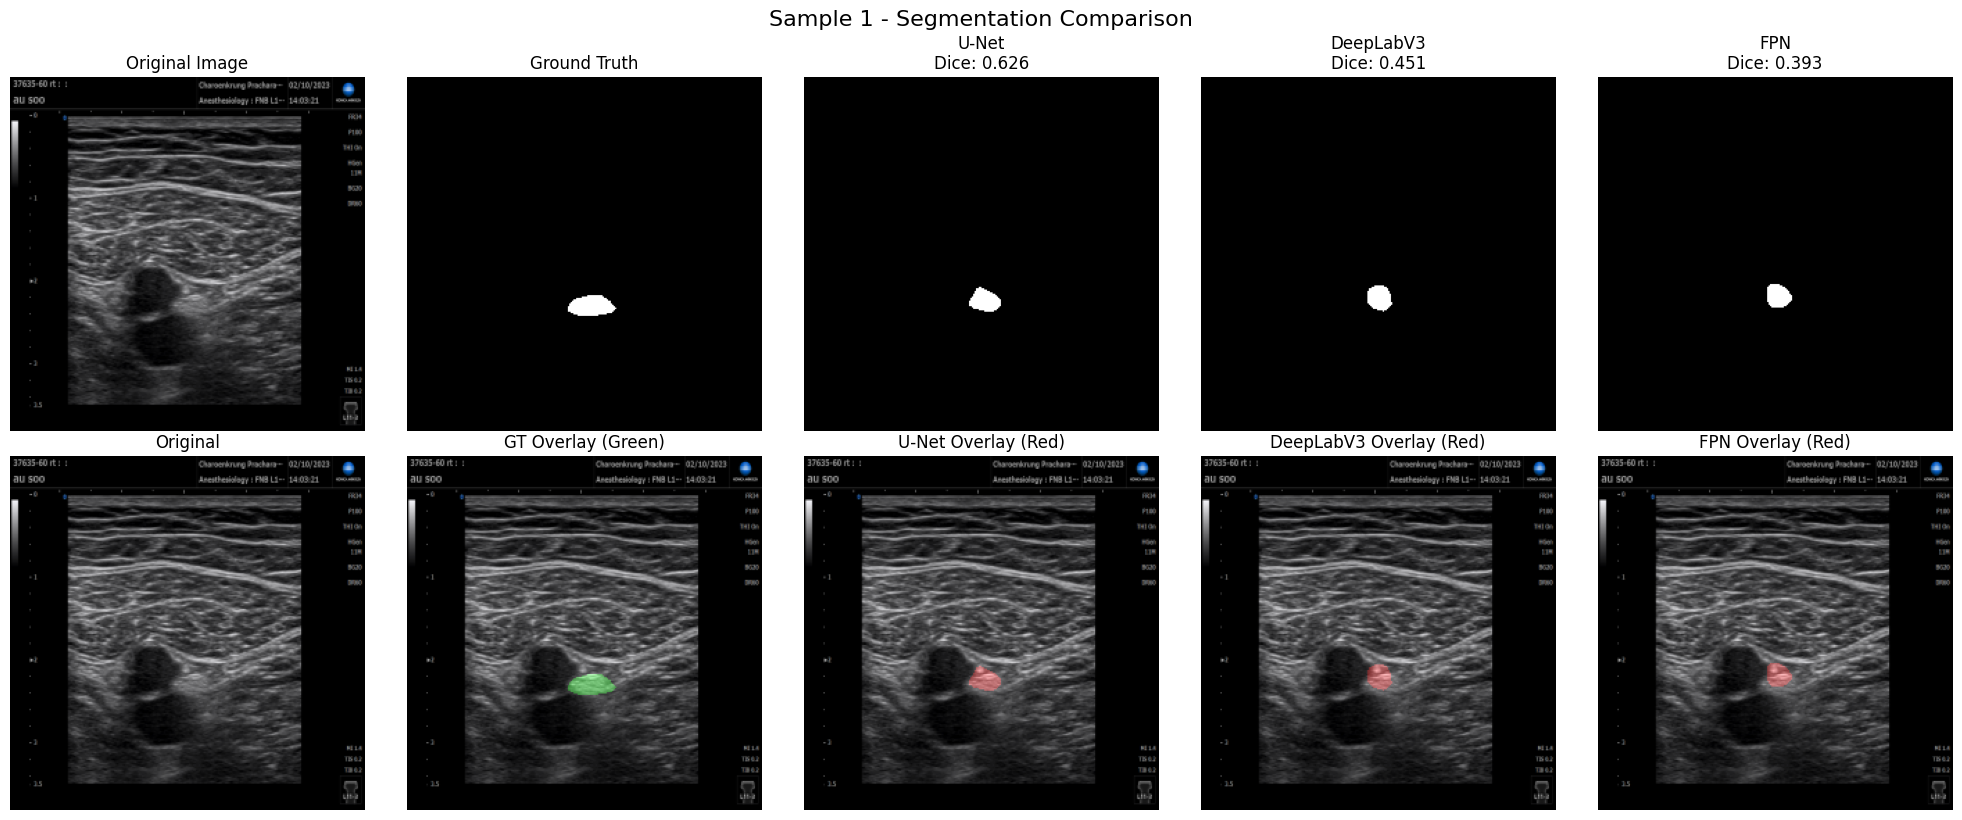

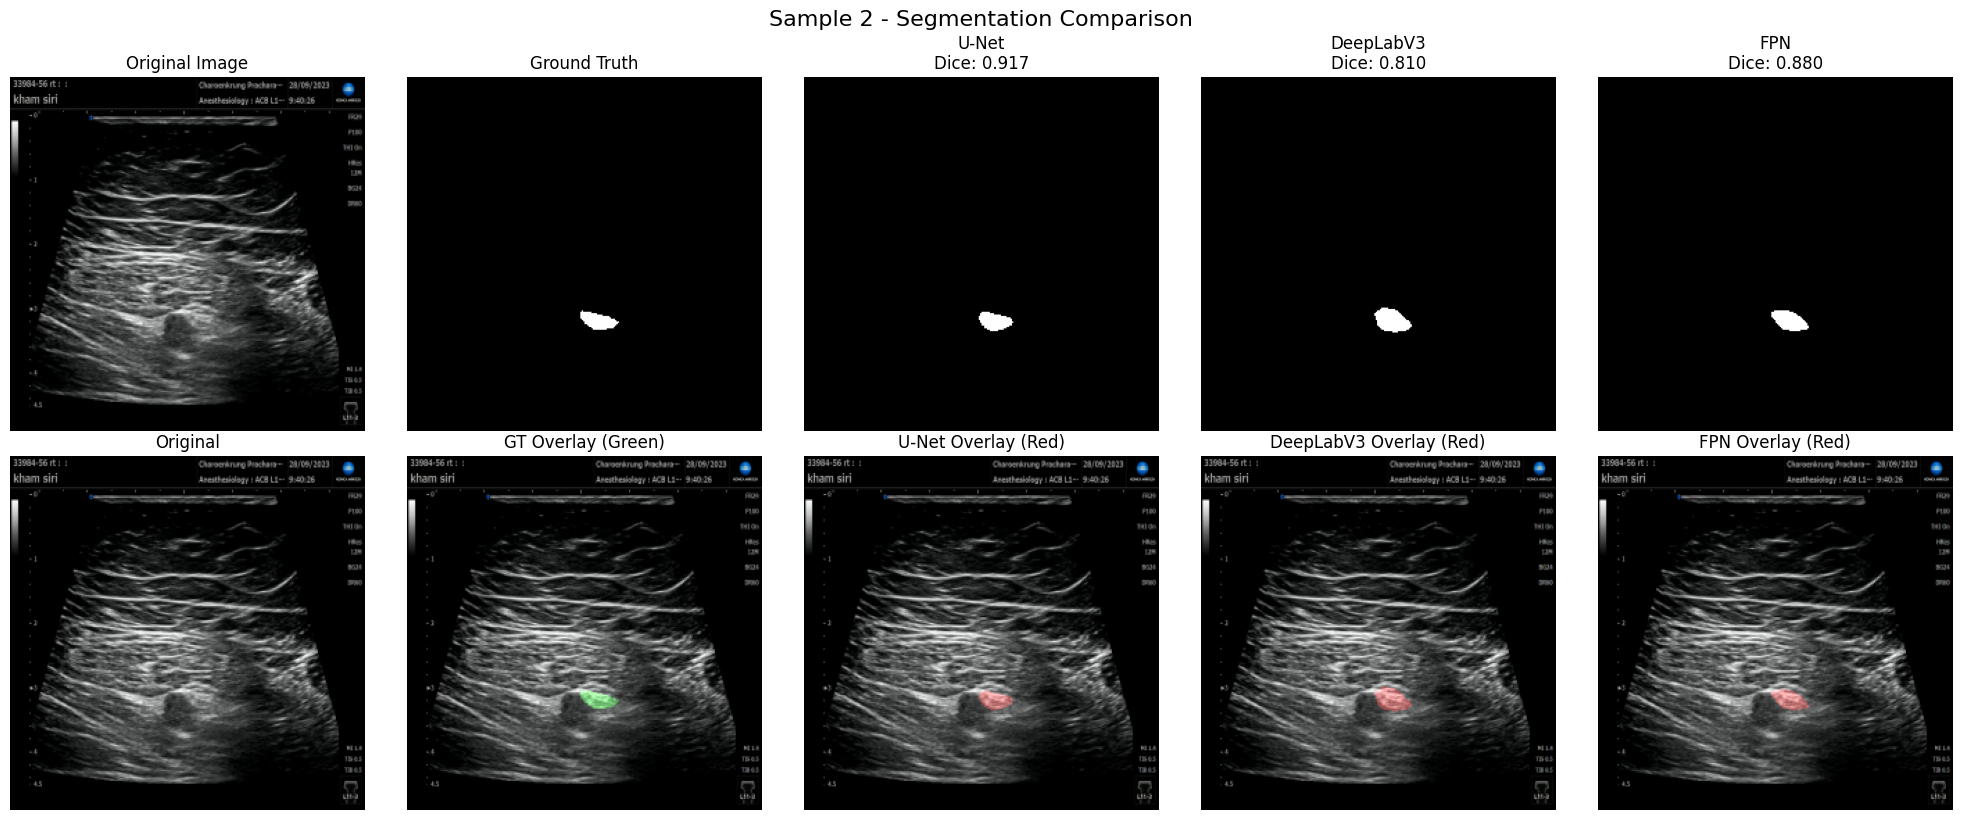

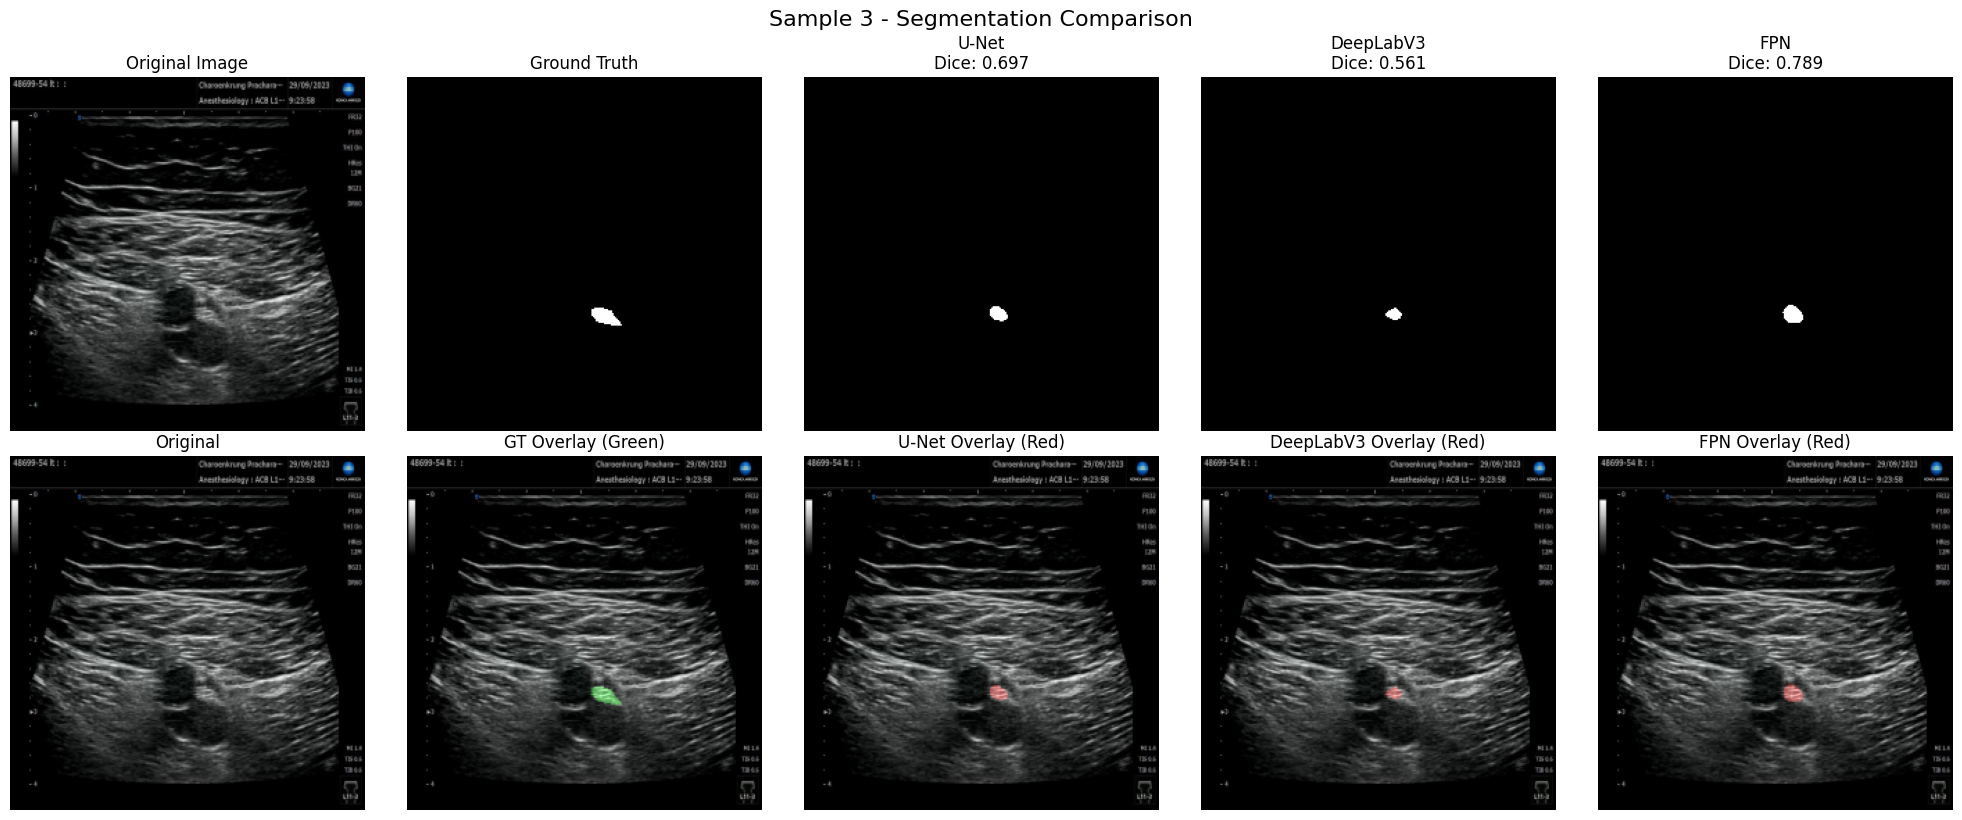


Analyzing best and worst performing cases...
Analyzing test set performance...


100%|██████████| 8/8 [00:01<00:00,  7.63it/s]



U-Net Performance Analysis:
Mean Dice: 0.808 ± 0.092
Best Dice: 0.937
Worst Dice: 0.561
Best cases indices: [18 20  1] with Dice scores: [0.93710691 0.92675161 0.91735536]
Worst cases indices: [57 21  0] with Dice scores: [0.56127632 0.57586205 0.62573099]


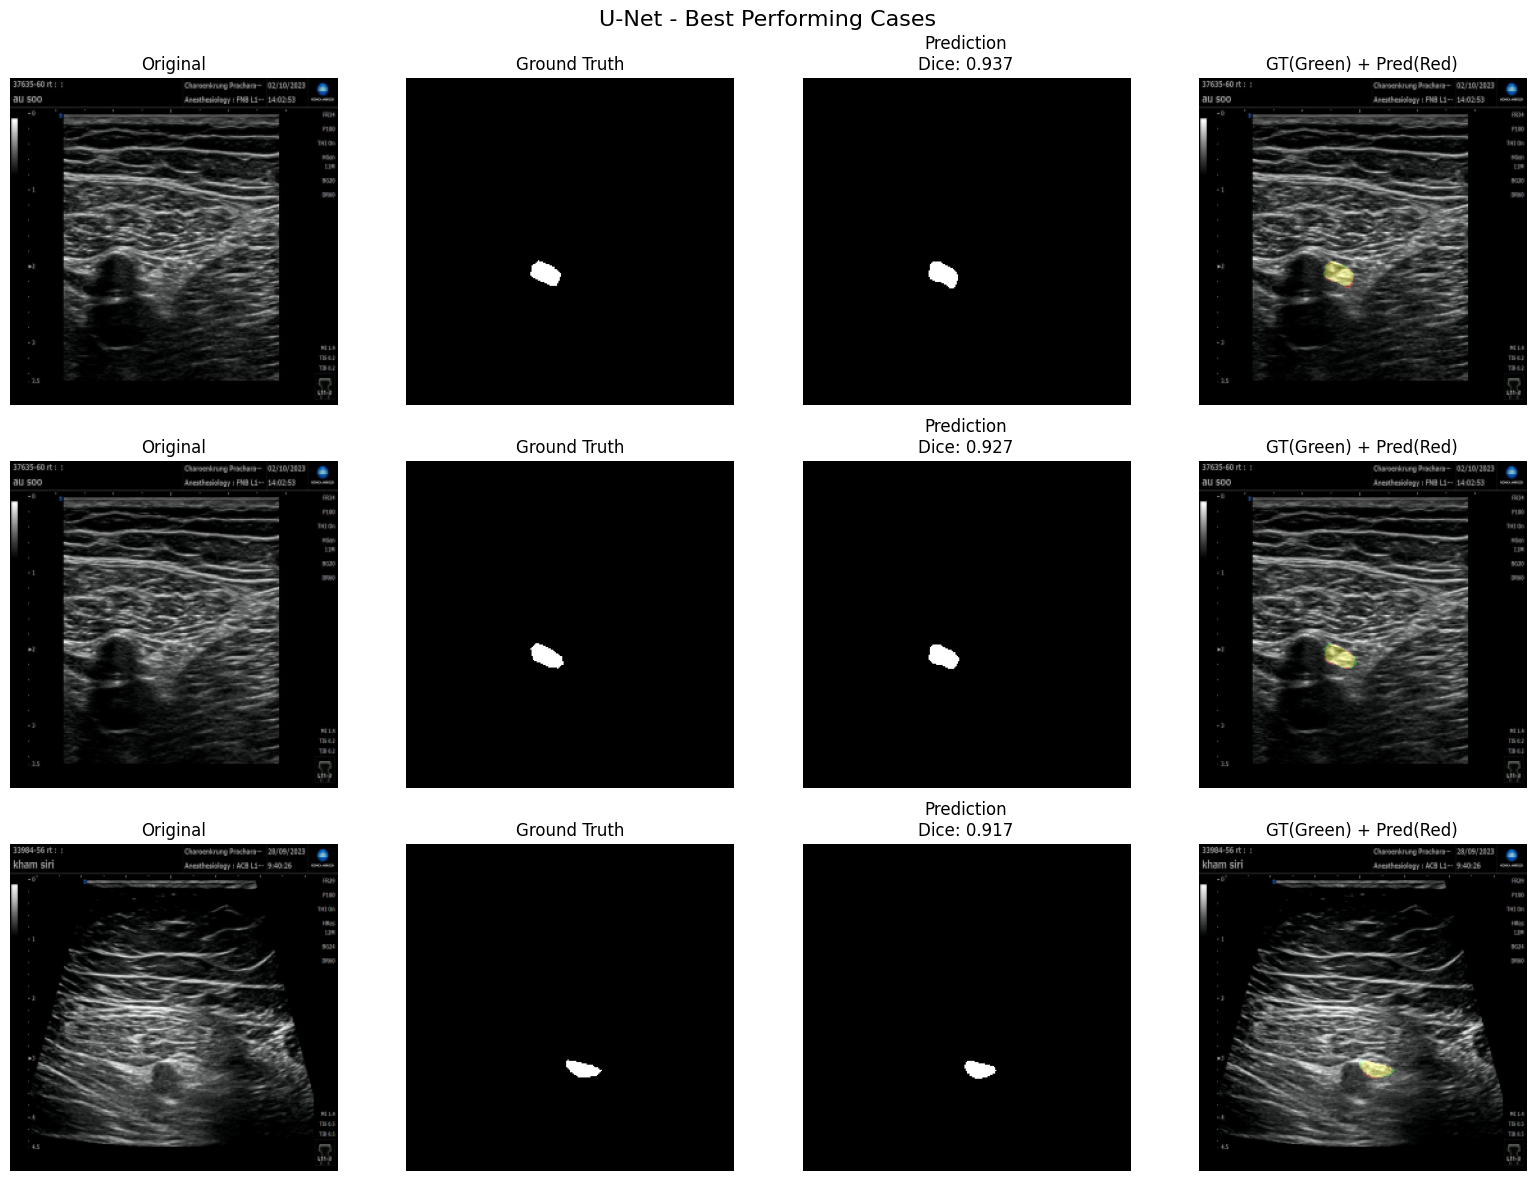

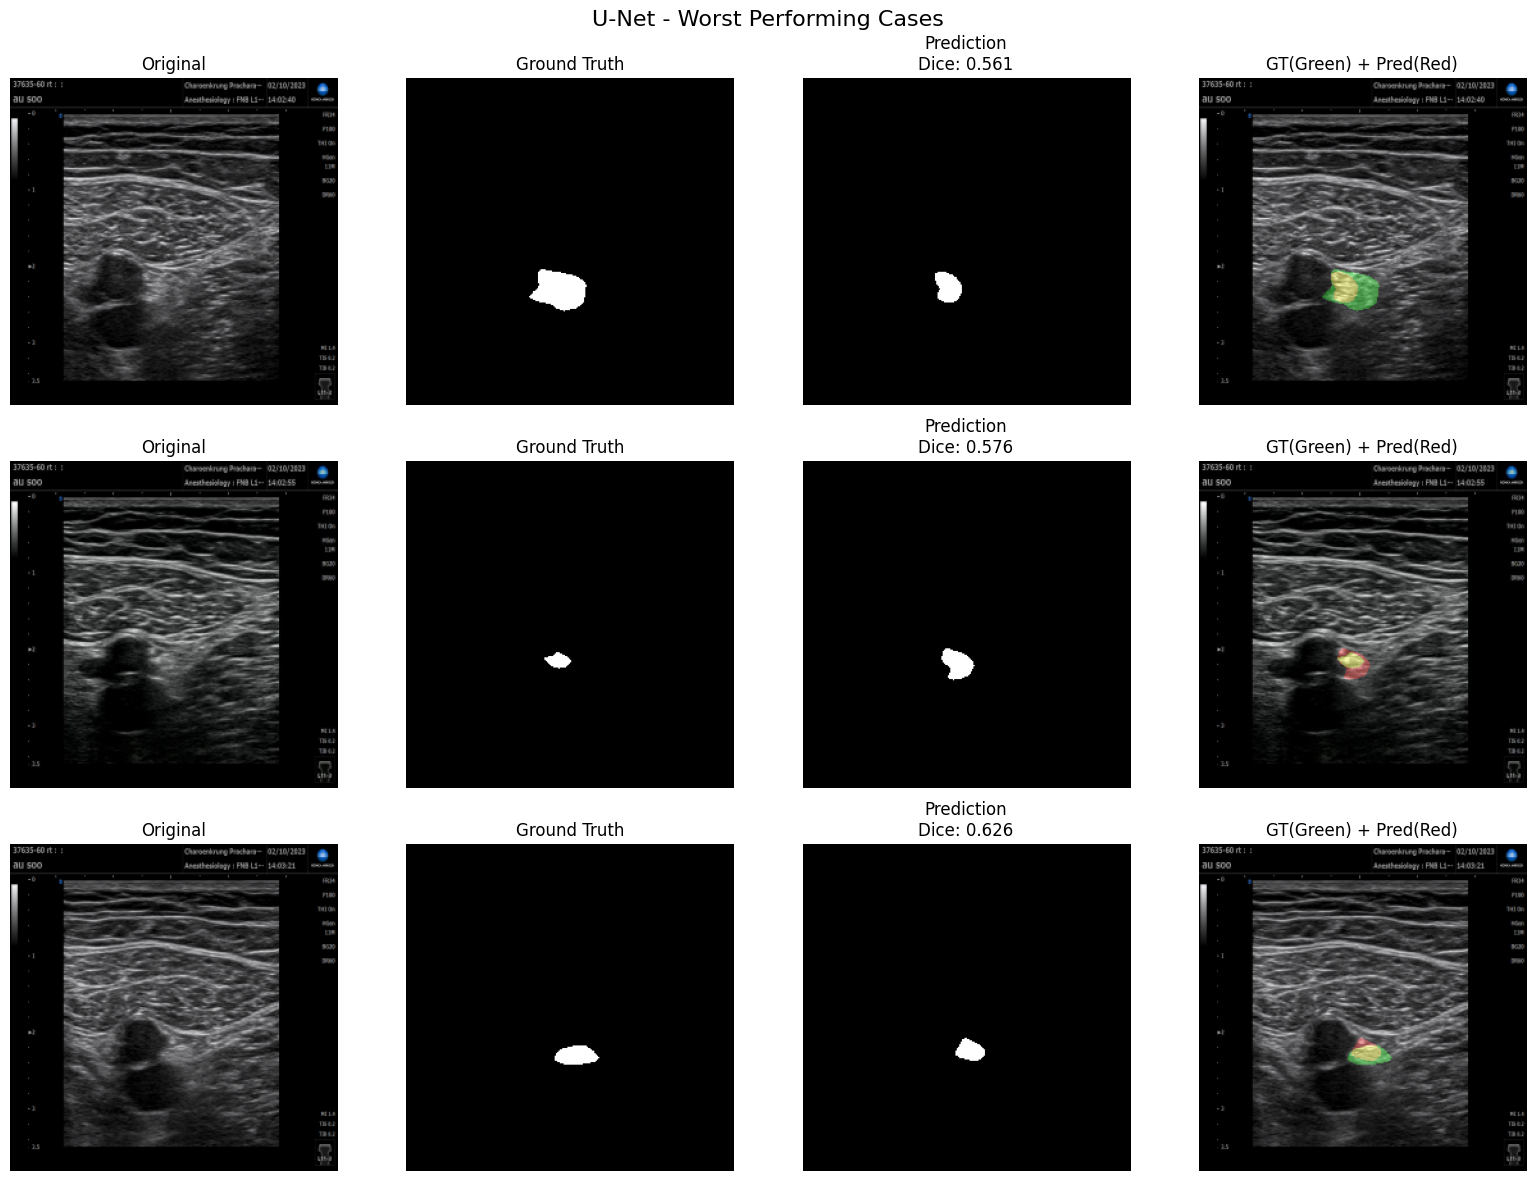


DeepLabV3 Performance Analysis:
Mean Dice: 0.750 ± 0.131
Best Dice: 0.900
Worst Dice: 0.211
Best cases indices: [14 25 50] with Dice scores: [0.8995536  0.89385474 0.89312345]
Worst cases indices: [40 53  0] with Dice scores: [0.21118012 0.33265167 0.45083207]


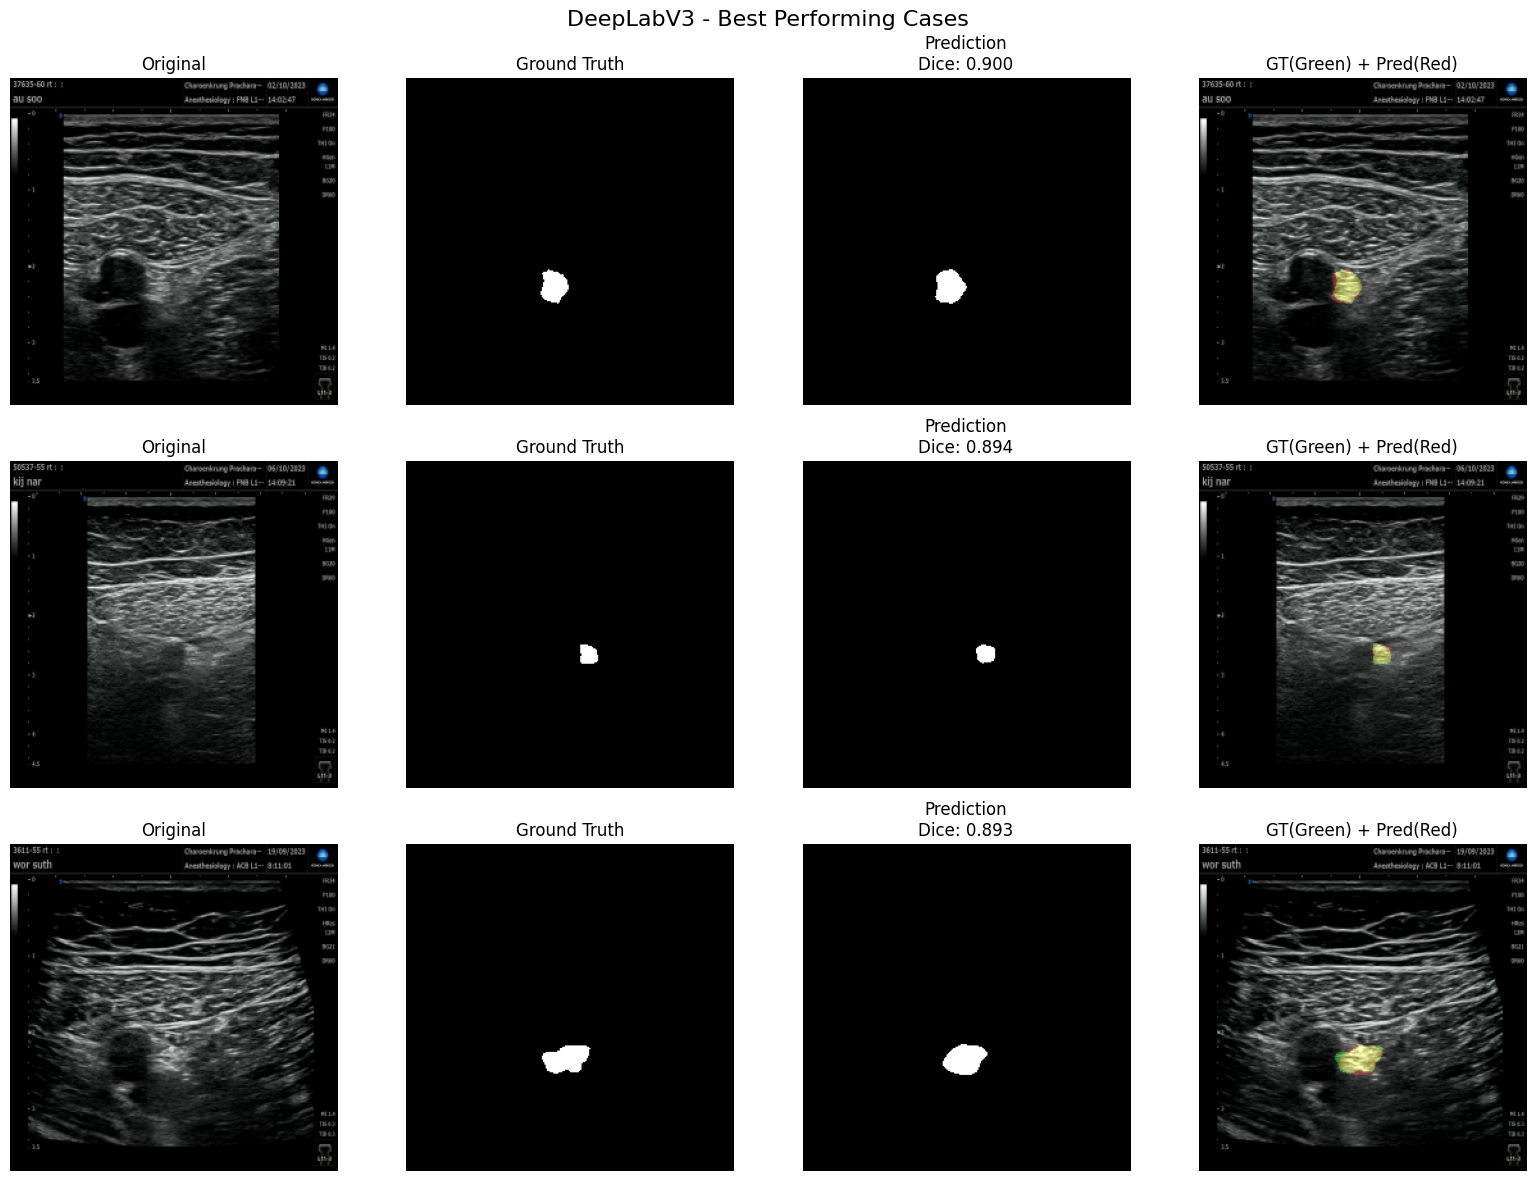

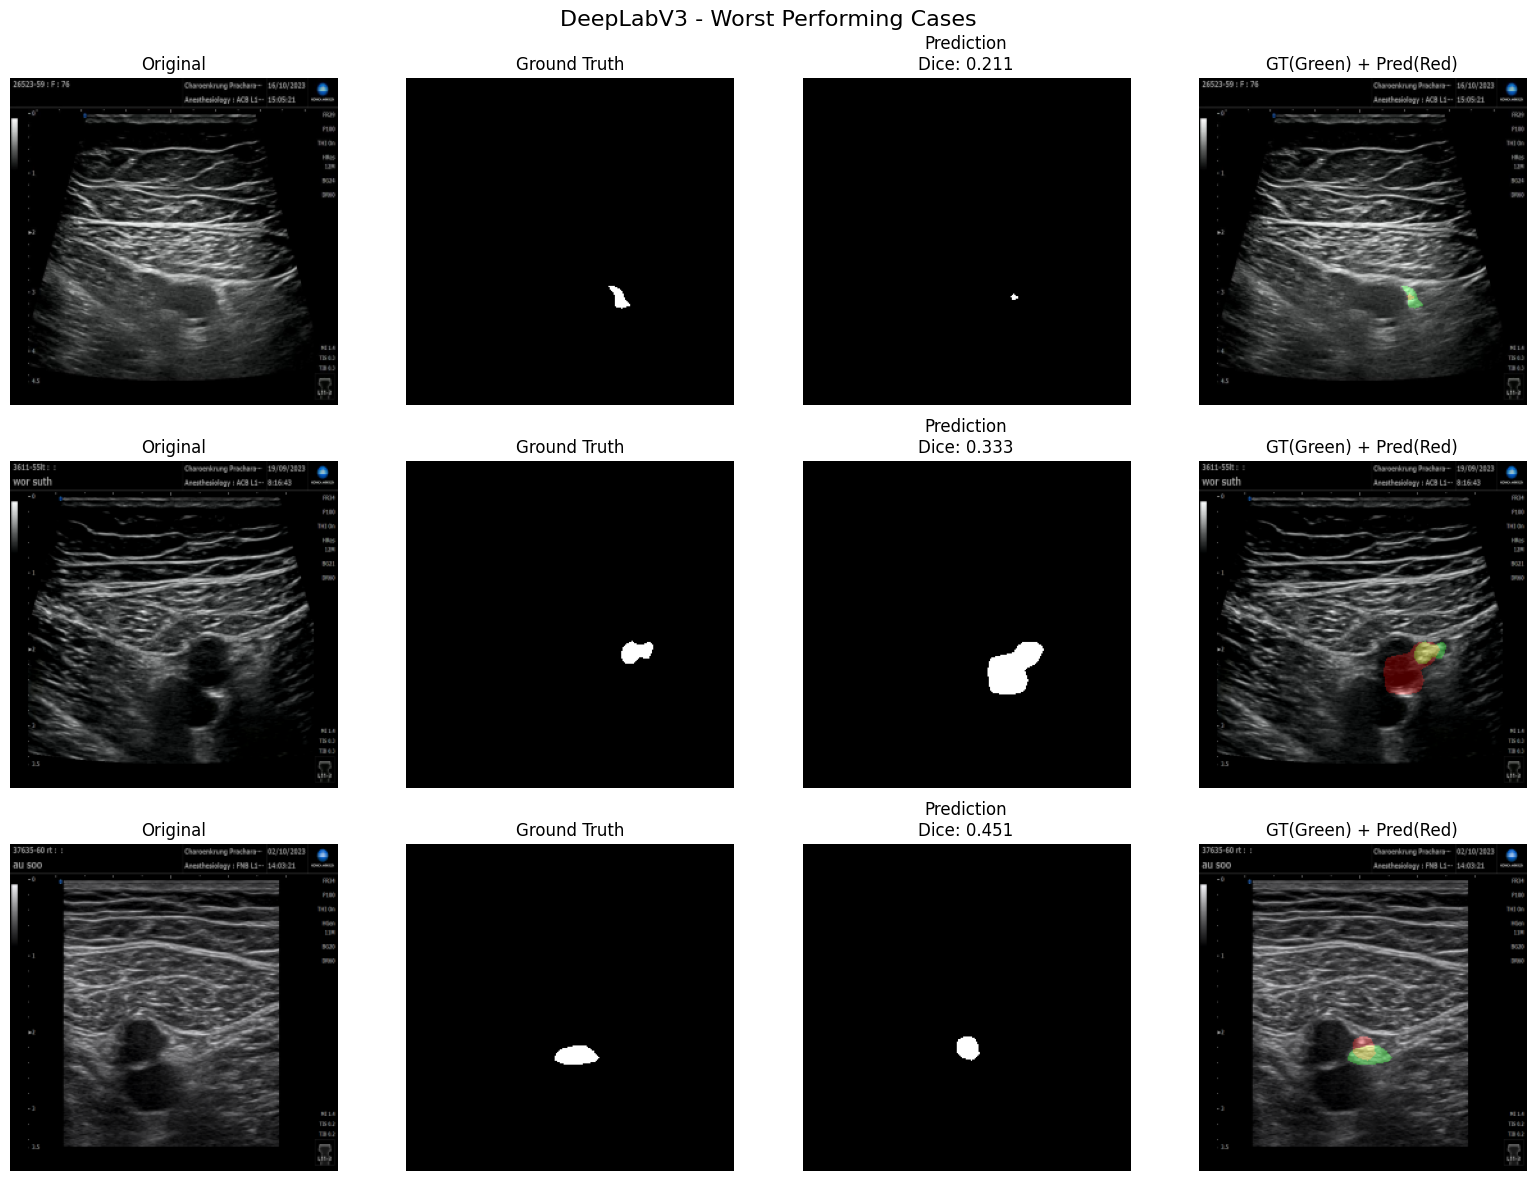


FPN Performance Analysis:
Mean Dice: 0.798 ± 0.089
Best Dice: 0.927
Worst Dice: 0.393
Best cases indices: [50 14 13] with Dice scores: [0.92654425 0.91071427 0.90140843]
Worst cases indices: [ 0 57 59] with Dice scores: [0.39318886 0.60478199 0.63461536]


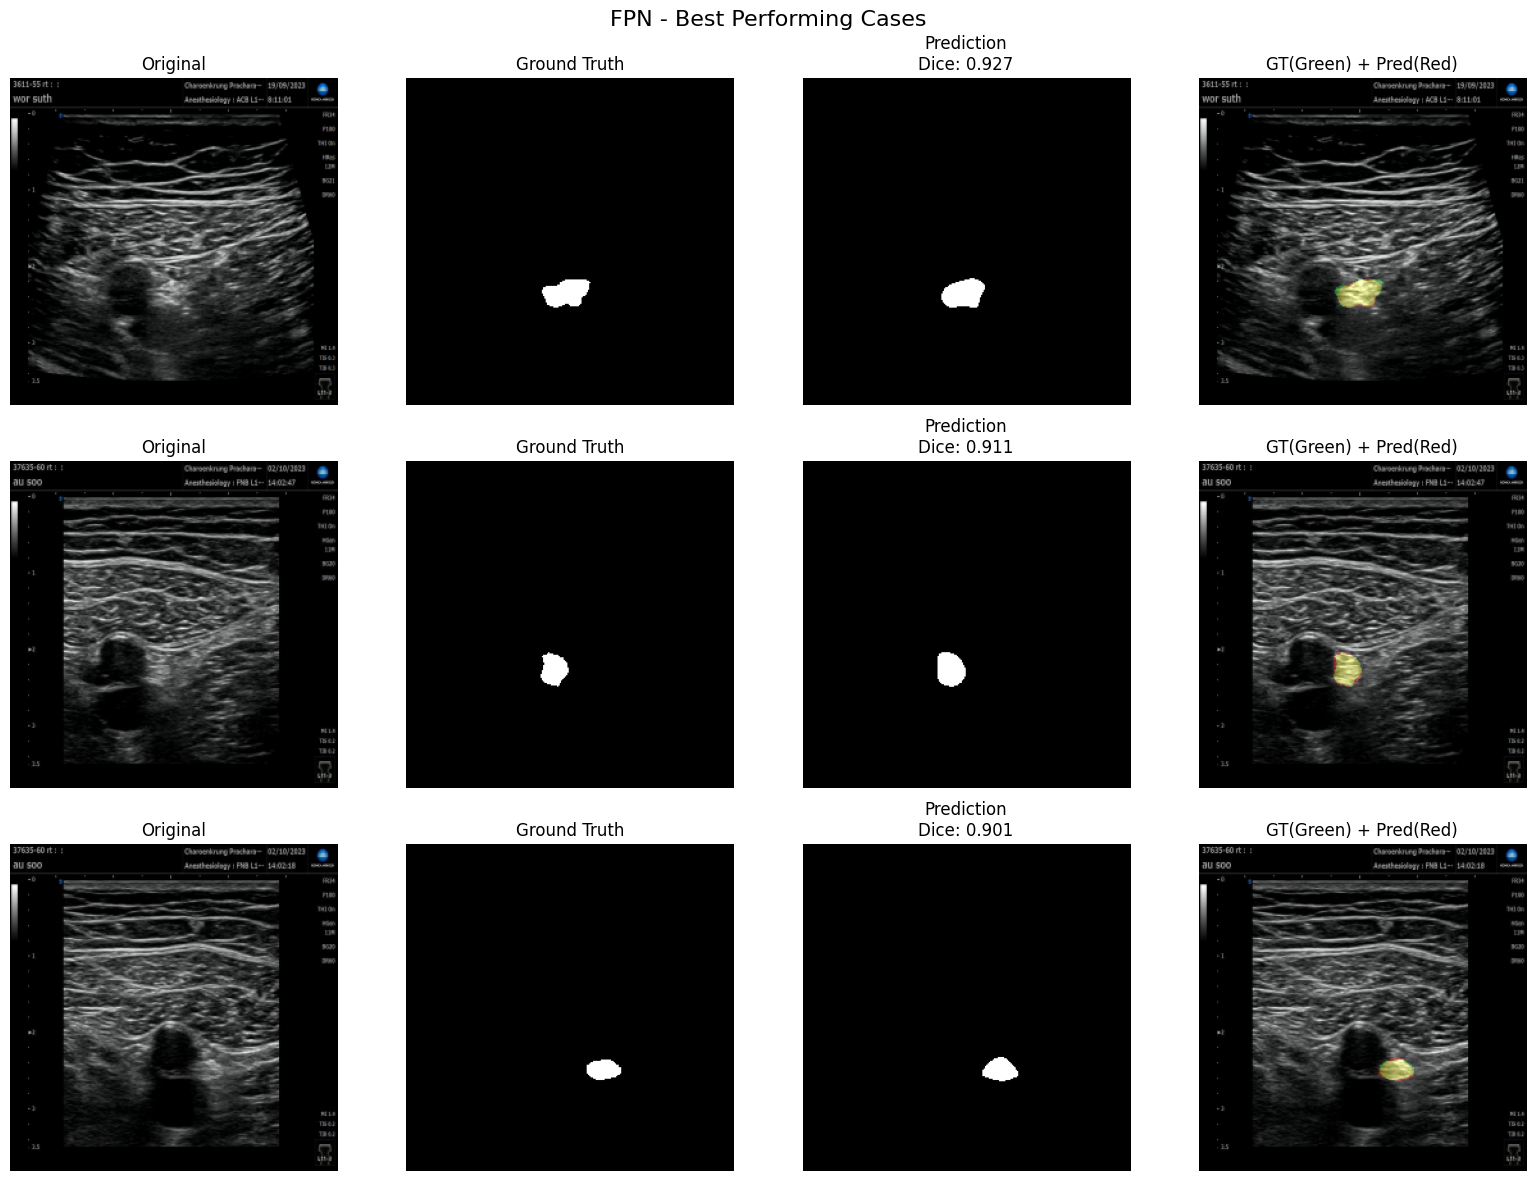

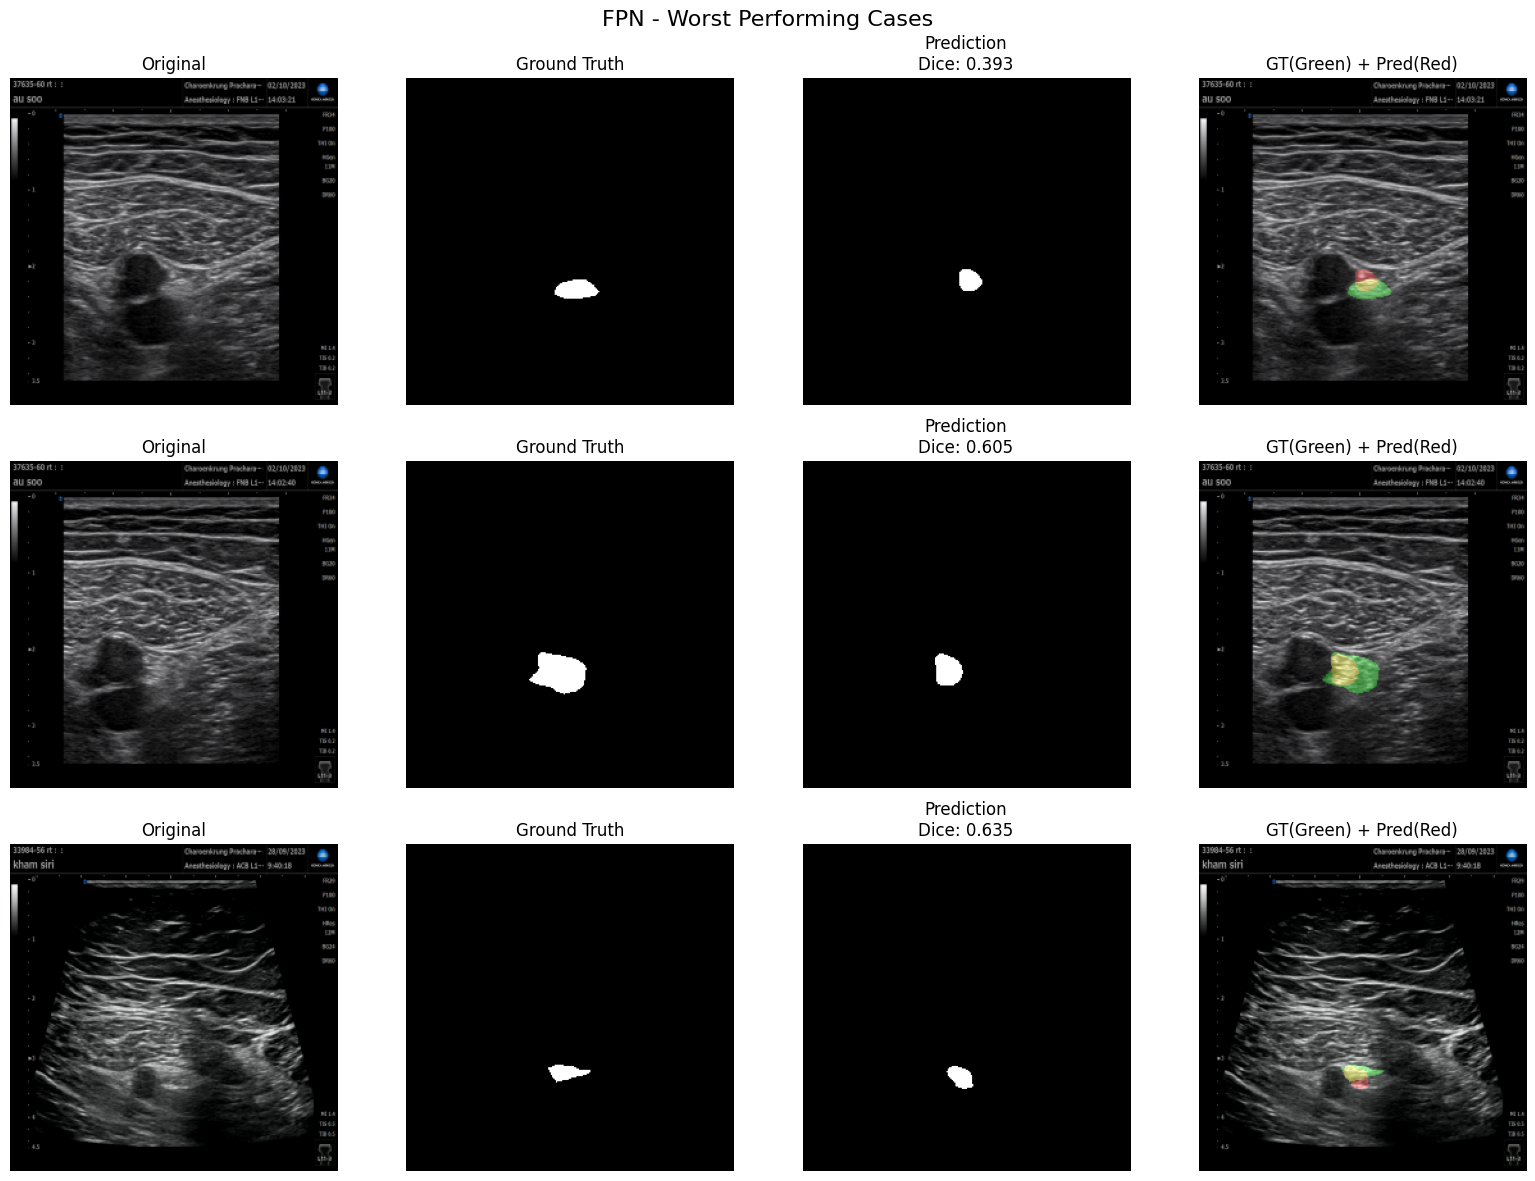

In [24]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import os

# Load the best models
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load U-Net
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load("best_unet.pth"))
unet_model.eval()

# Load DeepLabV3
deeplab_model = DeepLabV3().to(device)
deeplab_model.load_state_dict(torch.load("best_deeplabv3.pth"))
deeplab_model.eval()

# Load FPN
fpn_model = FPNNet().to(device)
fpn_model.load_state_dict(torch.load("best_fpn.pth"))
fpn_model.eval()

def predict_and_visualize(models, test_loader, num_examples=6):
    """
    Visualize predictions from all models and compare them
    """
    model_names = ["U-Net", "DeepLabV3", "FPN"]
    
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, masks = next(data_iter)
    images, masks = images.to(device), masks.to(device)
    
    # Get predictions from all models
    predictions = []
    dice_scores = []
    
    with torch.no_grad():
        for model in models:
            preds = model(images)
            predictions.append(preds.cpu())
            
            # Calculate dice scores for each image in batch
            batch_dice = []
            for i in range(preds.shape[0]):
                dice = dice_score(preds[i:i+1], masks[i:i+1])
                batch_dice.append(dice)
            dice_scores.append(batch_dice)
    
    # Select examples to show (best and worst performers)
    num_examples = min(num_examples, images.shape[0])
    
    for idx in range(num_examples):
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        
        # Original image
        img = images[idx].cpu()
        # Denormalize for display
        mean = torch.tensor([0.11803523, 0.12175034, 0.12110489]).view(3, 1, 1)
        std = torch.tensor([0.16351671, 0.16600904, 0.16600859]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        axes[0, 0].imshow(img.permute(1, 2, 0))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Ground truth mask
        mask = masks[idx].cpu().squeeze()
        axes[0, 1].imshow(mask, cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[0, 1].axis('off')
        
        # Model predictions
        for i, (pred, name, dice_batch) in enumerate(zip(predictions, model_names, dice_scores)):
            pred_mask = (pred[idx].squeeze() > 0.5).float()
            axes[0, i+2].imshow(pred_mask, cmap='gray')
            axes[0, i+2].set_title(f'{name}\nDice: {dice_batch[idx]:.3f}')
            axes[0, i+2].axis('off')
        
        # Show overlays (prediction on original image)
        for i, (pred, name, dice_batch) in enumerate(zip(predictions, model_names, dice_scores)):
            # Create overlay
            overlay = img.permute(1, 2, 0).clone()
            pred_mask = (pred[idx].squeeze() > 0.5).float()
            
            # Add red overlay where prediction is positive
            overlay[:, :, 0] = torch.where(pred_mask > 0.5, 
                                         torch.clamp(overlay[:, :, 0] + 0.3, 0, 1), 
                                         overlay[:, :, 0])
            
            if i == 0:
                axes[1, 0].imshow(img.permute(1, 2, 0))
                axes[1, 0].set_title('Original')
                axes[1, 0].axis('off')
                
                # Ground truth overlay
                gt_overlay = img.permute(1, 2, 0).clone()
                gt_overlay[:, :, 1] = torch.where(mask > 0.5,
                                                torch.clamp(gt_overlay[:, :, 1] + 0.3, 0, 1),
                                                gt_overlay[:, :, 1])
                axes[1, 1].imshow(gt_overlay)
                axes[1, 1].set_title('GT Overlay (Green)')
                axes[1, 1].axis('off')
            
            axes[1, i+2].imshow(overlay)
            axes[1, i+2].set_title(f'{name} Overlay (Red)')
            axes[1, i+2].axis('off')
        
        plt.tight_layout()
        plt.suptitle(f'Sample {idx+1} - Segmentation Comparison', y=1.02, fontsize=16)
        plt.show()

def analyze_performance_cases(models, test_loader, threshold_good=0.8, threshold_bad=0.3):
    """
    Find and display best and worst performing cases
    """
    model_names = ["U-Net", "DeepLabV3", "FPN"]
    all_dice_scores = [[] for _ in range(len(models))]
    all_images = []
    all_masks = []
    all_predictions = [[] for _ in range(len(models))]
    
    print("Analyzing test set performance...")
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader)):
            images, masks = images.to(device), masks.to(device)
            
            batch_predictions = []
            for model_idx, model in enumerate(models):
                preds = model(images)
                batch_predictions.append(preds.cpu())
                
                # Calculate dice for each image in batch
                for i in range(preds.shape[0]):
                    dice = dice_score(preds[i:i+1], masks[i:i+1])
                    all_dice_scores[model_idx].append(dice)
            
            # Store data for visualization
            all_images.extend([img.cpu() for img in images])
            all_masks.extend([mask.cpu() for mask in masks])
            for model_idx in range(len(models)):
                all_predictions[model_idx].extend([pred for pred in batch_predictions[model_idx]])
    
    # Convert to numpy for easier handling
    for model_idx in range(len(models)):
        all_dice_scores[model_idx] = np.array(all_dice_scores[model_idx])
    
    # Find best and worst cases for each model
    for model_idx, (model_name, dice_scores) in enumerate(zip(model_names, all_dice_scores)):
        print(f"\n{model_name} Performance Analysis:")
        print(f"Mean Dice: {dice_scores.mean():.3f} ± {dice_scores.std():.3f}")
        print(f"Best Dice: {dice_scores.max():.3f}")
        print(f"Worst Dice: {dice_scores.min():.3f}")
        
        # Find indices of best and worst cases
        best_indices = np.argsort(dice_scores)[-3:][::-1]  # Top 3
        worst_indices = np.argsort(dice_scores)[:3]        # Bottom 3
        
        print(f"Best cases indices: {best_indices} with Dice scores: {dice_scores[best_indices]}")
        print(f"Worst cases indices: {worst_indices} with Dice scores: {dice_scores[worst_indices]}")
        
        # Visualize best cases
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle(f'{model_name} - Best Performing Cases', fontsize=16)
        
        for i, idx in enumerate(best_indices):
            # Original image
            img = all_images[idx]
            mean = torch.tensor([0.11803523, 0.12175034, 0.12110489]).view(3, 1, 1)
            std = torch.tensor([0.16351671, 0.16600904, 0.16600859]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[i, 0].imshow(img.permute(1, 2, 0))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            # Ground truth
            mask = all_masks[idx].squeeze()
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Prediction
            pred = (all_predictions[model_idx][idx].squeeze() > 0.5).float()
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title(f'Prediction\nDice: {dice_scores[idx]:.3f}')
            axes[i, 2].axis('off')
            
            # Overlay
            overlay = img.permute(1, 2, 0).clone()
            # Green for GT, Red for prediction
            overlay[:, :, 1] = torch.where(mask > 0.5,
                                         torch.clamp(overlay[:, :, 1] + 0.3, 0, 1),
                                         overlay[:, :, 1])
            overlay[:, :, 0] = torch.where(pred > 0.5,
                                         torch.clamp(overlay[:, :, 0] + 0.3, 0, 1),
                                         overlay[:, :, 0])
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('GT(Green) + Pred(Red)')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize worst cases
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle(f'{model_name} - Worst Performing Cases', fontsize=16)
        
        for i, idx in enumerate(worst_indices):
            # Original image
            img = all_images[idx]
            mean = torch.tensor([0.11803523, 0.12175034, 0.12110489]).view(3, 1, 1)
            std = torch.tensor([0.16351671, 0.16600904, 0.16600859]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[i, 0].imshow(img.permute(1, 2, 0))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            # Ground truth
            mask = all_masks[idx].squeeze()
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Prediction
            pred = (all_predictions[model_idx][idx].squeeze() > 0.5).float()
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title(f'Prediction\nDice: {dice_scores[idx]:.3f}')
            axes[i, 2].axis('off')
            
            # Overlay
            overlay = img.permute(1, 2, 0).clone()
            # Green for GT, Red for prediction
            overlay[:, :, 1] = torch.where(mask > 0.5,
                                         torch.clamp(overlay[:, :, 1] + 0.3, 0, 1),
                                         overlay[:, :, 1])
            overlay[:, :, 0] = torch.where(pred > 0.5,
                                         torch.clamp(overlay[:, :, 0] + 0.3, 0, 1),
                                         overlay[:, :, 0])
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('GT(Green) + Pred(Red)')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()

# Run the visualizations
models = [unet_model, deeplab_model, fpn_model]

print("Generating comparison visualizations...")
predict_and_visualize(models, test_loader, num_examples=3)

print("\nAnalyzing best and worst performing cases...")
analyze_performance_cases(models, test_loader)